<a href="https://colab.research.google.com/github/specM7/CM2604_ML_CSW_Malindu/blob/main/CM2604_Task2Classification_2425440.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [284]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, classification_report,
                           confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate  # For beautiful table formatting
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


#### Data Loading and Cleaning

In [285]:
# Load the dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"✓ Dataset loaded: {data.shape[0]} rows × {data.shape[1]} columns")

# Clean TotalCharges column
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
missing_charges = data['TotalCharges'].isnull().sum()
print(f"✓ Converted TotalCharges to numeric, found {missing_charges} missing values")

# Fill missing values
data['TotalCharges'] = data['TotalCharges'].fillna(0)
print(f"✓ Filled missing TotalCharges with 0")

# Convert SeniorCitizen to categorical
data['SeniorCitizen'] = data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
print(f"✓ Converted SeniorCitizen to categorical (0 to No, 1 to Yes)")

✓ Dataset loaded: 7043 rows × 21 columns
✓ Converted TotalCharges to numeric, found 11 missing values
✓ Filled missing TotalCharges with 0
✓ Converted SeniorCitizen to categorical (0 to No, 1 to Yes)


#### Prepare features and target variable

In [286]:
# Define target variable
data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})
y = data['Churn']

print(f"✓ Target variable encoded: 0=No Churn, 1=Churn")
print(f"  Class distribution: {y.value_counts().to_dict()}")
print(f"  Churn rate: {y.mean():.2%}")

# Define features
X = data.drop(['customerID', 'Churn'], axis=1)

# Define feature types
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

print(f"✓ Features identified:")
print(f"  - Numerical: {', '.join(numeric_features)}")
print(f"  - Categorical: {len(categorical_features)} features:", ', '.join(categorical_features))

✓ Target variable encoded: 0=No Churn, 1=Churn
  Class distribution: {0: 5174, 1: 1869}
  Churn rate: 26.54%
✓ Features identified:
  - Numerical: tenure, MonthlyCharges, TotalCharges
  - Categorical: 16 features: gender, SeniorCitizen, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod


#### Data Preprocessing Pipeline

In [287]:
# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("✓ Preprocessing pipeline created with:")
print("  - Numerical: Median imputation + Standard scaling")
print("  - Categorical: Mode imputation + One-hot encoding")

✓ Preprocessing pipeline created with:
  - Numerical: Median imputation + Standard scaling
  - Categorical: Mode imputation + One-hot encoding


#### Data splitting to test/train


In [288]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Data split with stratification:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set:     {X_test.shape[0]} samples")
print(f"  Features:     {X_train.shape[1]}")

# Show class distribution
train_churn_rate = y_train.mean()
test_churn_rate = y_test.mean()
print(f"\nClass balance:")
print(f"  Training - Churn: {y_train.sum():>4} ({train_churn_rate:.2%})")
print(f"           - No Churn: {len(y_train)-y_train.sum():>4} ({1-train_churn_rate:.2%})")
print(f"  Test     - Churn: {y_test.sum():>4} ({test_churn_rate:.2%})")
print(f"           - No Churn: {len(y_test)-y_test.sum():>4} ({1-test_churn_rate:.2%})")

✓ Data split with stratification:
  Training set: 5634 samples
  Test set:     1409 samples
  Features:     19

Class balance:
  Training - Churn: 1495 (26.54%)
           - No Churn: 4139 (73.46%)
  Test     - Churn:  374 (26.54%)
           - No Churn: 1035 (73.46%)


#### Decision Tree Model

In [289]:

#False negatives for churn should be reduced even if false positives increase
custom_weights = {0: 1, 1: 1.15}
print(f"   Class 0 (No Churn): weight = {custom_weights[0]:.1f}")
print(f"   Class 1 (Churn): weight = {custom_weights[1]:.1f}")

print(f"\n Selected weights: {custom_weights}")

 # Decision Tree pipeline with SMOTE oversampling
dt_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])


print("\n5.1 Model Configuration:")
print("-"*40)
print("Pipeline: Preprocessing to Decision Tree")
print("Base parameters:")
print("  - random_state: 42")
print("  - class_weight: custom - churn prioritised (handles class imbalance)")
print("  - criterion: 'gini' (default)")
print()

# Define hyperparameter grid
dt_param_grid = {
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': ['balanced',custom_weights]
}

print("5.2 Hyperparameter Tuning:")
print("-"*40)
print("Searching parameter space with RandomizedSearchCV:")
for param, values in dt_param_grid.items():
    param_name = param.replace('classifier__', '')
    print(f"  {param_name:<20}: {values}")

# Perform hyperparameter tuning
dt_search = RandomizedSearchCV(
    dt_pipeline,
    dt_param_grid,
    n_iter=15,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("\n✓ Training Decision Tree with hyperparameter tuning...")
dt_search.fit(X_train, y_train)
print("✓ Training completed!")

# Get best model
best_dt = dt_search.best_estimator_

print(f"\n5.3 Best Hyperparameters Found:")
print("-"*40)
for param, value in dt_search.best_params_.items():
    param_name = param.replace('classifier__', '')
    print(f"  {param_name:<20}: {value}")
print(f"  Best CV Score (ROC-AUC): {dt_search.best_score_:.4f}")

   Class 0 (No Churn): weight = 1.0
   Class 1 (Churn): weight = 1.1

 Selected weights: {0: 1, 1: 1.15}

5.1 Model Configuration:
----------------------------------------
Pipeline: Preprocessing to Decision Tree
Base parameters:
  - random_state: 42
  - class_weight: custom - churn prioritised (handles class imbalance)
  - criterion: 'gini' (default)

5.2 Hyperparameter Tuning:
----------------------------------------
Searching parameter space with RandomizedSearchCV:
  max_depth           : [5, 10, 15, 20, None]
  min_samples_split   : [2, 5, 10]
  min_samples_leaf    : [1, 2, 4]
  max_features        : ['sqrt', 'log2', None]
  class_weight        : ['balanced', {0: 1, 1: 1.15}]

✓ Training Decision Tree with hyperparameter tuning...
✓ Training completed!

5.3 Best Hyperparameters Found:
----------------------------------------
  min_samples_split   : 10
  min_samples_leaf    : 2
  max_features        : None
  max_depth           : 5
  class_weight        : {0: 1, 1: 1.15}
  Best CV 

#### Neural Network model


In [290]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

nn_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', SMOTE(random_state=42)),
    ('classifier', MLPClassifier(
        random_state=42,
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    ))
])

print("\n6.1 Model Configuration:")
print("-"*40)
print("Pipeline: Preprocessing → Multi-layer Perceptron")
print("Base parameters:")
print("  - random_state: 42")
print("  - max_iter: 1000")
print("  - early_stopping: True (prevents overfitting)")
print("  - validation_fraction: 0.1")
print("  - n_iter_no_change: 10")
print()

# Define hyperparameter grid
nn_param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01],
    'classifier__batch_size': [32, 64],
    'classifier__activation': ['relu'],
}

print("6.2 Hyperparameter Tuning:")
print("-"*40)
print("Searching parameter space with RandomizedSearchCV:")
for param, values in nn_param_grid.items():
    param_name = param.replace('classifier__', '')
    print(f"  {param_name:<20}: {values}")

# Perform hyperparameter tuning
nn_search = RandomizedSearchCV(
    nn_pipeline,
    nn_param_grid,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    n_jobs=1,  # MLP doesn't parallelize well
    random_state=42,
    verbose=0
)

print("\n✓ Training Neural Network with hyperparameter tuning...")
nn_search.fit(X_train, y_train)
print("✓ Training completed!")

# Get best model
best_nn = nn_search.best_estimator_

print(f"\n6.3 Best Hyperparameters Found:")
print("-"*40)
for param, value in nn_search.best_params_.items():
    param_name = param.replace('classifier__', '')
    print(f"  {param_name:<20}: {value}")
print(f"  Best CV Score (ROC-AUC): {nn_search.best_score_:.4f}")



6.1 Model Configuration:
----------------------------------------
Pipeline: Preprocessing → Multi-layer Perceptron
Base parameters:
  - random_state: 42
  - max_iter: 1000
  - early_stopping: True (prevents overfitting)
  - validation_fraction: 0.1
  - n_iter_no_change: 10

6.2 Hyperparameter Tuning:
----------------------------------------
Searching parameter space with RandomizedSearchCV:
  hidden_layer_sizes  : [(50,), (100,), (50, 50), (100, 50)]
  alpha               : [0.0001, 0.001, 0.01]
  learning_rate_init  : [0.001, 0.01]
  batch_size          : [32, 64]
  activation          : ['relu']

✓ Training Neural Network with hyperparameter tuning...
✓ Training completed!

6.3 Best Hyperparameters Found:
----------------------------------------
  learning_rate_init  : 0.001
  hidden_layer_sizes  : (50,)
  batch_size          : 64
  alpha               : 0.001
  activation          : relu
  Best CV Score (ROC-AUC): 0.8429


#### Model evaluation

In [291]:
def evaluate_model_with_details(model, X_test, y_test, model_name):
    """
    Comprehensive evaluation with detailed metric output
    """
    print("\n" + "="*80)
    print(f"EVALUATION: {model_name}")
    print("="*80)

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Additional derived metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

    # ========================================================================
    # METRICS TABLE 1: PRIMARY EVALUATION METRICS
    # ========================================================================
    print("\n1. PRIMARY EVALUATION METRICS")
    print("-"*40)

    metrics_table1 = [
        ["Accuracy", f"{accuracy:.4f}",
         "Overall correctness of predictions",
         f"{accuracy*100:.1f}% of predictions are correct"],

        ["Precision", f"{precision:.4f}",
         "Quality of positive predictions",
         f"When predicts 'Churn', {precision*100:.1f}% are correct"],

        ["Recall (Sensitivity)", f"{recall:.4f}",
         "Ability to identify churners",
         f"Identifies {recall*100:.1f}% of actual churners"],

        ["F1-Score", f"{f1:.4f}",
         "Harmonic mean of Precision & Recall",
         "Balance between precision and recall"],

        ["ROC-AUC", f"{roc_auc:.4f}",
         "Overall ranking performance",
         "Probability of ranking random churner higher than non-churner"],

        ["Specificity", f"{specificity:.4f}",
         "Ability to identify non-churners",
         f"Correctly identifies {specificity*100:.1f}% of non-churners"]
    ]

    print(tabulate(metrics_table1,
                   headers=["Metric", "Value", "Description", "Interpretation"],
                   tablefmt="grid",
                   stralign="left"))

    # ========================================================================
    # CONFUSION MATRIX DETAILS
    # ========================================================================
    print("\n\n2. CONFUSION MATRIX ANALYSIS")
    print("-"*40)

    cm_table = [
        ["", "Predicted: No Churn", "Predicted: Churn", "Total Actual"],
        ["Actual: No Churn", f"{tn}", f"{fp}", f"{tn + fp}"],
        ["Actual: Churn", f"{fn}", f"{tp}", f"{fn + tp}"],
        ["Total Predicted", f"{tn + fn}", f"{fp + tp}", f"{len(y_test)}"]
    ]

    print(tabulate(cm_table, headers="firstrow", tablefmt="grid"))

    # Error rates
    print(f"\nError Analysis:")
    error_table = [
        ["False Positive Rate (Type I Error)", f"{fpr:.4f}",
         f"{fp}/{fp+tn}", "Non-churner flagged as churner"],

        ["False Negative Rate (Type II Error)", f"{fnr:.4f}",
         f"{fn}/{fn+tp}", "Churner missed"],

        ["Negative Predictive Value", f"{npv:.4f}",
         f"{tn}/{tn+fn}", f"When predicts 'No Churn', {npv*100:.1f}% are correct"]
    ]

    print(tabulate(error_table,
                   headers=["Error Metric", "Value", "Ratio", "Interpretation"],
                   tablefmt="simple",
                   stralign="left"))

    # ========================================================================
    # CLASSIFICATION REPORT
    # ========================================================================
    print("\n\n3. DETAILED CLASSIFICATION REPORT")
    print("-"*40)

    # Generate classification report as dictionary
    report_dict = classification_report(y_test, y_pred,
                                        target_names=['No Churn', 'Churn'],
                                        output_dict=True,
                                        zero_division=0)

    # Convert to table format
    report_table = []
    for class_name in ['No Churn', 'Churn', 'weighted avg', 'macro avg']:
        if class_name in report_dict:
            metrics = report_dict[class_name]
            if class_name in ['weighted avg', 'macro avg']:
                report_table.append([
                    class_name,
                    f"{metrics.get('precision', 0):.4f}",
                    f"{metrics.get('recall', 0):.4f}",
                    f"{metrics.get('f1-score', 0):.4f}",
                    f"{metrics.get('support', 0):.0f}"
                ])
            else:
                report_table.append([
                    class_name,
                    f"{metrics['precision']:.4f}",
                    f"{metrics['recall']:.4f}",
                    f"{metrics['f1-score']:.4f}",
                    f"{metrics['support']:.0f}"
                ])

    print(tabulate(report_table,
                   headers=["Class", "Precision", "Recall", "F1-Score", "Support"],
                   tablefmt="grid"))

    # ========================================================================
    # PERFORMANCE SUMMARY
    # ========================================================================
    print("\n\n4. PERFORMANCE SUMMARY")
    print("-"*40)

    # Business impact metrics (simplified)
    total_customers = len(y_test)
    actual_churners = y_test.sum()
    predicted_churners = (y_pred == 1).sum()

    # Assuming costs (for illustration)
    cost_missed_churn = 500  # Cost of losing a customer
    cost_false_alarm = 50    # Cost of unnecessary retention effort

    missed_churn_cost = fn * cost_missed_churn
    false_alarm_cost = fp * cost_false_alarm
    total_cost = missed_churn_cost + false_alarm_cost

    summary_table = [
        ["Total test customers", f"{total_customers}"],
        ["Actual churners", f"{actual_churners} ({actual_churners/total_customers:.1%})"],
        ["Predicted churners", f"{predicted_churners} ({predicted_churners/total_customers:.1%})"],
        ["True churners identified", f"{tp}/{actual_churners} ({tp/actual_churners:.1%})"],
        ["False alarms", f"{fp} customers flagged incorrectly"],
        ["Missed churners", f"{fn} churners not detected"],
    ]

    print(tabulate(summary_table,
                   headers=["Metric", "Value"],
                   tablefmt="grid",
                   stralign="left"))

    print(f"\n   💡 Cost assumptions:")
    print(f"   - Missing a churner costs: ${cost_missed_churn:,.0f}")
    print(f"   - False alarm costs: ${cost_false_alarm:,.0f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'npv': npv,
        'fpr': fpr,
        'fnr': fnr,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    }

#### Evaluating both models

In [292]:
# Evaluate Decision Tree
dt_metrics = evaluate_model_with_details(best_dt, X_test, y_test, "DECISION TREE")

# Evaluate Neural Network
nn_metrics = evaluate_model_with_details(best_nn, X_test, y_test, "NEURAL NETWORK")



EVALUATION: DECISION TREE

1. PRIMARY EVALUATION METRICS
----------------------------------------
+----------------------+---------+-------------------------------------+---------------------------------------------------------------+
| Metric               |   Value | Description                         | Interpretation                                                |
+======================+=========+=====================================+===============================================================+
| Accuracy             |  0.7303 | Overall correctness of predictions  | 73.0% of predictions are correct                              |
+----------------------+---------+-------------------------------------+---------------------------------------------------------------+
| Precision            |  0.4947 | Quality of positive predictions     | When predicts 'Churn', 49.5% are correct                      |
+----------------------+---------+-------------------------------------+-------

#### Visualization of results

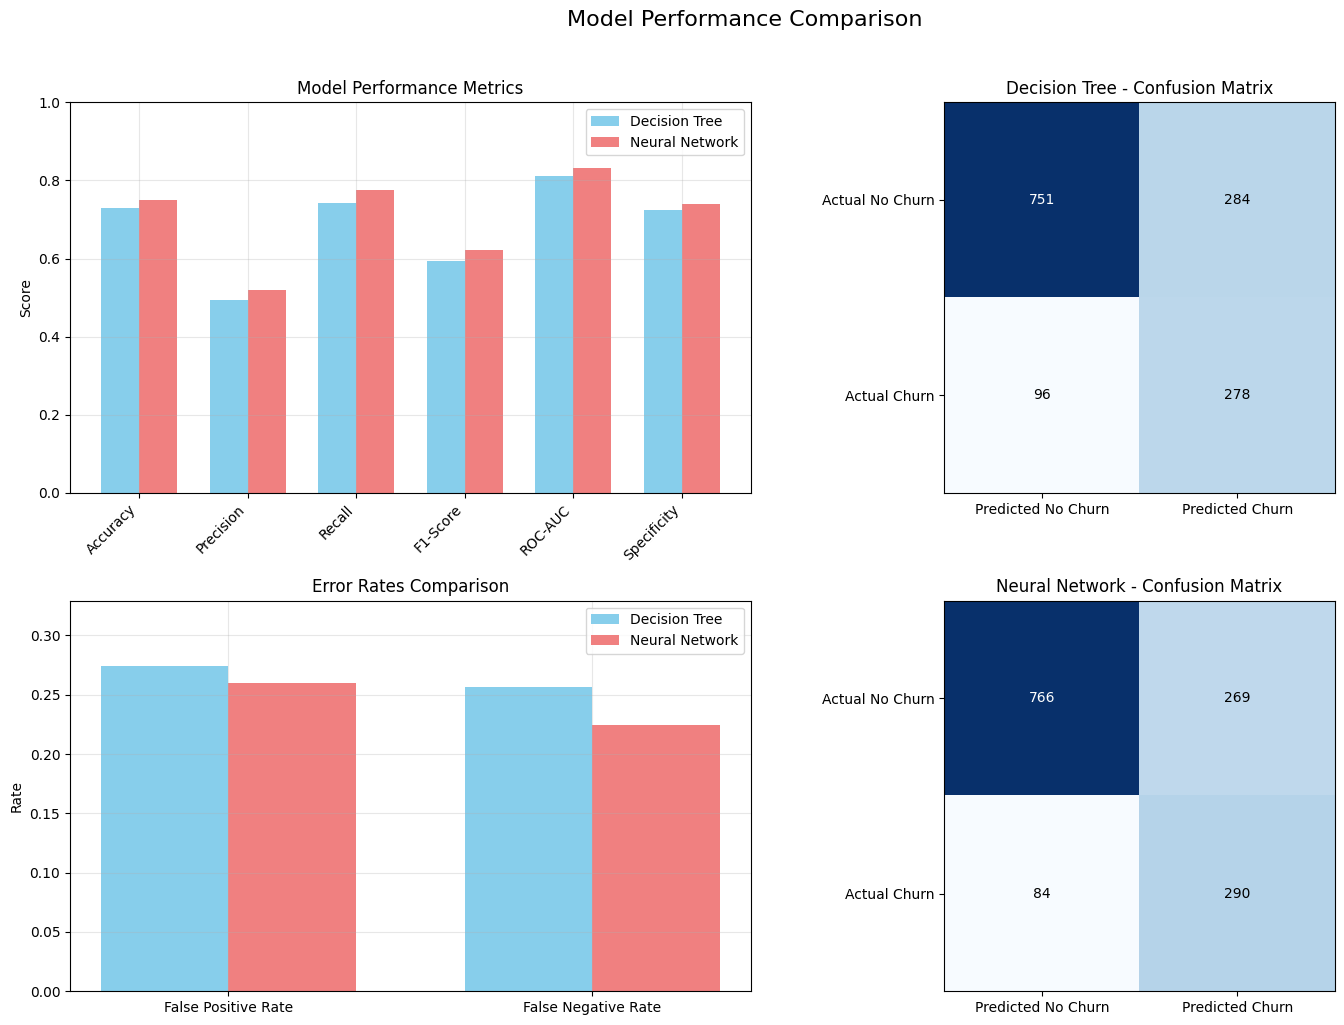

In [293]:
# Create visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, y=1.02)

# Plot 1: Accuracy and ROC-AUC
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Specificity']
# Create a mapping from display names to dictionary keys
metric_mapping = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1-Score': 'f1',
    'ROC-AUC': 'roc_auc',
    'Specificity': 'specificity'
}

dt_values = [dt_metrics[metric_mapping[m]] for m in metrics_to_plot]
nn_values = [nn_metrics[metric_mapping[m]] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

axes[0, 0].bar(x - width/2, dt_values, width, label='Decision Tree', color='skyblue')
axes[0, 0].bar(x + width/2, nn_values, width, label='Neural Network', color='lightcoral')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Metrics')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Confusion Matrix Comparison
def plot_confusion_matrix_subplot(ax, cm, title):
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(['Predicted No Churn', 'Predicted Churn'])
    ax.set_yticklabels(['Actual No Churn', 'Actual Churn'])

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

# Decision Tree Confusion Matrix
cm_dt = np.array([[dt_metrics['tn'], dt_metrics['fp']],
                  [dt_metrics['fn'], dt_metrics['tp']]])
plot_confusion_matrix_subplot(axes[0, 1], cm_dt, 'Decision Tree - Confusion Matrix')

# Neural Network Confusion Matrix
cm_nn = np.array([[nn_metrics['tn'], nn_metrics['fp']],
                  [nn_metrics['fn'], nn_metrics['tp']]])
plot_confusion_matrix_subplot(axes[1, 1], cm_nn, 'Neural Network - Confusion Matrix')

# Plot 3: Error Rates Comparison
error_rates = ['FPR', 'FNR']
dt_errors = [dt_metrics['fpr'], dt_metrics['fnr']]
nn_errors = [nn_metrics['fpr'], nn_metrics['fnr']]

x_error = np.arange(len(error_rates))
axes[1, 0].bar(x_error - width/2, dt_errors, width, label='Decision Tree', color='skyblue')
axes[1, 0].bar(x_error + width/2, nn_errors, width, label='Neural Network', color='lightcoral')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_title('Error Rates Comparison')
axes[1, 0].set_xticks(x_error)
axes[1, 0].set_xticklabels(['False Positive Rate', 'False Negative Rate'])
axes[1, 0].legend()
axes[1, 0].set_ylim([0, max(max(dt_errors), max(nn_errors)) * 1.2])
axes[1, 0].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Final Summary output

In [294]:
# Create summary table
final_summary = [
    ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Total Cost"],  # This line was missing a comma
    ["Decision Tree",
     f"{dt_metrics['accuracy']:.3f}",
     f"{dt_metrics['precision']:.3f}",
     f"{dt_metrics['recall']:.3f}",
     f"{dt_metrics['f1']:.3f}",
     f"{dt_metrics['roc_auc']:.3f}"],

    ["Neural Network",
     f"{nn_metrics['accuracy']:.3f}",
     f"{nn_metrics['precision']:.3f}",
     f"{nn_metrics['recall']:.3f}",
     f"{nn_metrics['f1']:.3f}",
     f"{nn_metrics['roc_auc']:.3f}"]
]

print(tabulate(final_summary, headers="firstrow", tablefmt="grid"))

+----------------+------------+-------------+----------+------------+-----------+
| Model          |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
+================+============+=============+==========+============+===========+
| Decision Tree  |      0.73  |       0.495 |    0.743 |      0.594 |     0.811 |
+----------------+------------+-------------+----------+------------+-----------+
| Neural Network |      0.749 |       0.519 |    0.775 |      0.622 |     0.832 |
+----------------+------------+-------------+----------+------------+-----------+
